In [24]:
from collections import Counter

label_dir = '/kaggle/input/annotations/labelTxt'
class_counts = Counter()

for file in os.listdir(label_dir):
    if not file.endswith('.txt'): continue
    with open(os.path.join(label_dir, file), 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 9:
                cls = parts[8]
                class_counts[cls] += 1

# Print top classes
print("Class distribution:")
for cls, count in class_counts.most_common():
    print(f"{cls}: {count}")

Class distribution:
ship: 28068
small-vehicle: 26126
large-vehicle: 16969
plane: 8055
harbor: 5983
storage-tank: 5029
tennis-court: 2367
bridge: 2047
swimming-pool: 1736
helicopter: 630
basketball-court: 515
baseball-diamond: 415
roundabout: 399
soccer-ball-field: 326
ground-track-field: 325


**PREPROCESSING**

Minor fraction of images were grayscale; model frameworks like YOLOv8 auto-handle this during loading. Explicit conversion was skipped to optimize preprocessing time.

In [25]:
import os
import shutil
import random
from glob import glob

In [26]:
# Paths
image_dir = '/kaggle/input/dota-data/DOTA/train/images'
label_dir = '/kaggle/working/yolo_labels'
base_out_dir = '/kaggle/working/yolo_dataset'

In [27]:
# Create required directories
for split in ['train', 'val']:
    os.makedirs(os.path.join(base_out_dir, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(base_out_dir, 'labels', split), exist_ok=True)

In [28]:
# Get all image files
all_images = sorted(glob(os.path.join(image_dir, '*.png')))
print(f"Total images found: {len(all_images)}")

Total images found: 1411


In [29]:
# Shuffle and split 80% train / 20% val
random.seed(42)
random.shuffle(all_images)
split_idx = int(0.8 * len(all_images))
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

In [30]:
# Helper to copy files
def copy_image_and_label(image_list, split):
    for img_path in image_list:
        fname = os.path.basename(img_path)
        label_path = os.path.join(label_dir, fname.replace('.png', '.txt'))

        # Copy image
        shutil.copy(img_path, os.path.join(base_out_dir, 'images', split, fname))

        # Copy label if it exists
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(base_out_dir, 'labels', split, fname.replace('.png', '.txt')))

In [31]:
# Copy to train and val
copy_image_and_label(train_images, 'train')
copy_image_and_label(val_images, 'val')

In [32]:
# Summary
print(f"Train images: {len(train_images)}")
print(f"Val images: {len(val_images)}")

Train images: 1128
Val images: 283


In [33]:
#Create data.yaml
import yaml

data_yaml = {
    'train': f'{base_out_dir}/images/train',
    'val': f'{base_out_dir}/images/val',
    'nc': 15,
    'names': [
        'plane', 'baseball-diamond', 'bridge', 'ground-track-field',
        'small-vehicle', 'large-vehicle', 'ship', 'tennis-court',
        'basketball-court', 'storage-tank', 'soccer-ball-field',
        'roundabout', 'harbor', 'swimming-pool', 'helicopter'
    ]
}

with open(f'{base_out_dir}/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

print("📄 data.yaml created at:", f'{base_out_dir}/data.yaml')

📄 data.yaml created at: /kaggle/working/yolo_dataset/data.yaml


In [34]:
#Validate Images and Labels
def validate_split(split):
    img_dir = os.path.join(base_out_dir, 'images', split)
    lbl_dir = os.path.join(base_out_dir, 'labels', split)

    img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
    lbl_files = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')]

    img_ids = set(os.path.splitext(f)[0] for f in img_files)
    lbl_ids = set(os.path.splitext(f)[0] for f in lbl_files)

    missing_labels = img_ids - lbl_ids
    missing_images = lbl_ids - img_ids

    print(f" {split.upper()} SET")
    print(f" Total Images : {len(img_ids)}")
    print(f" Total Labels : {len(lbl_ids)}")
    print(f" Missing Labels: {len(missing_labels)}")
    print(f" Missing Images: {len(missing_images)}")
    if missing_labels:
        print("Missing labels for:", list(missing_labels)[:5])
    if missing_images:
        print("Missing images for:", list(missing_images)[:5])
    print("")

validate_split('train')
validate_split('val')

 TRAIN SET
 Total Images : 1128
 Total Labels : 1128
 Missing Labels: 0
 Missing Images: 0

 VAL SET
 Total Images : 283
 Total Labels : 283
 Missing Labels: 0
 Missing Images: 0



 Showing: P0556.png


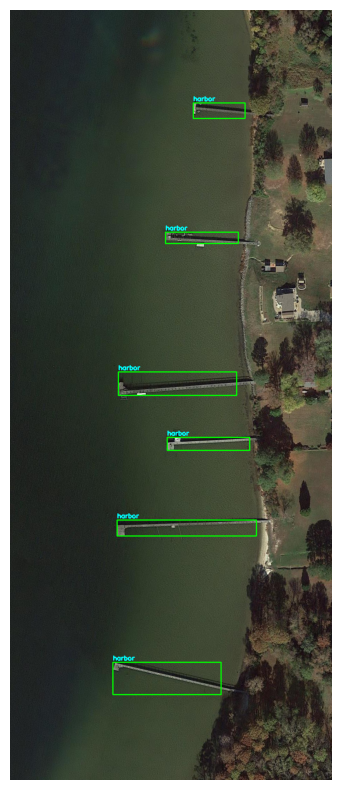

 Showing: P2047.png


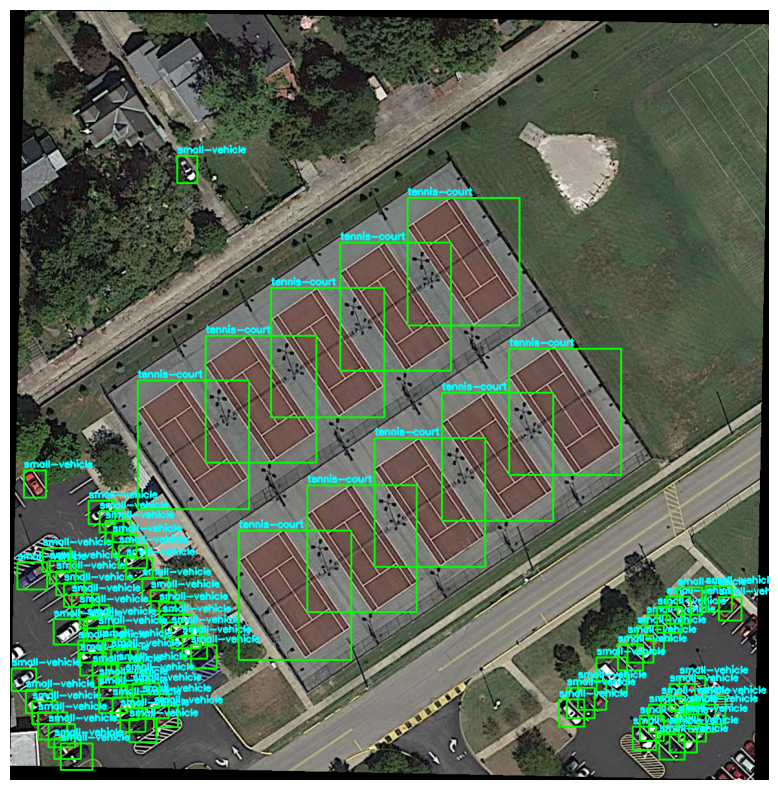

 Showing: P1818.png


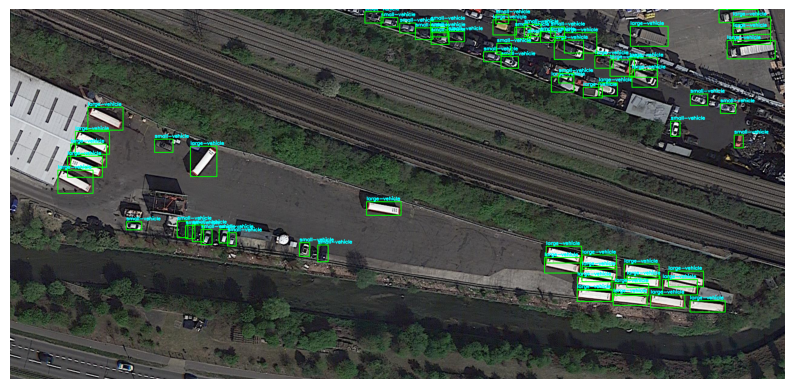

 Showing: P1391.png


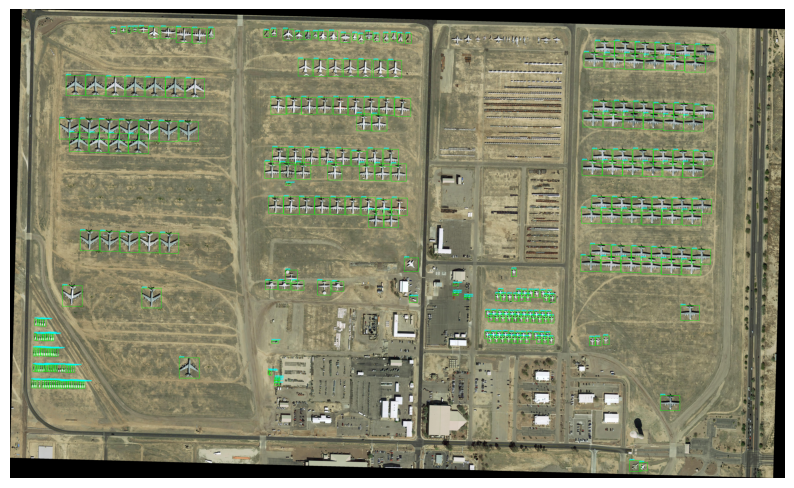

 Showing: P1614.png


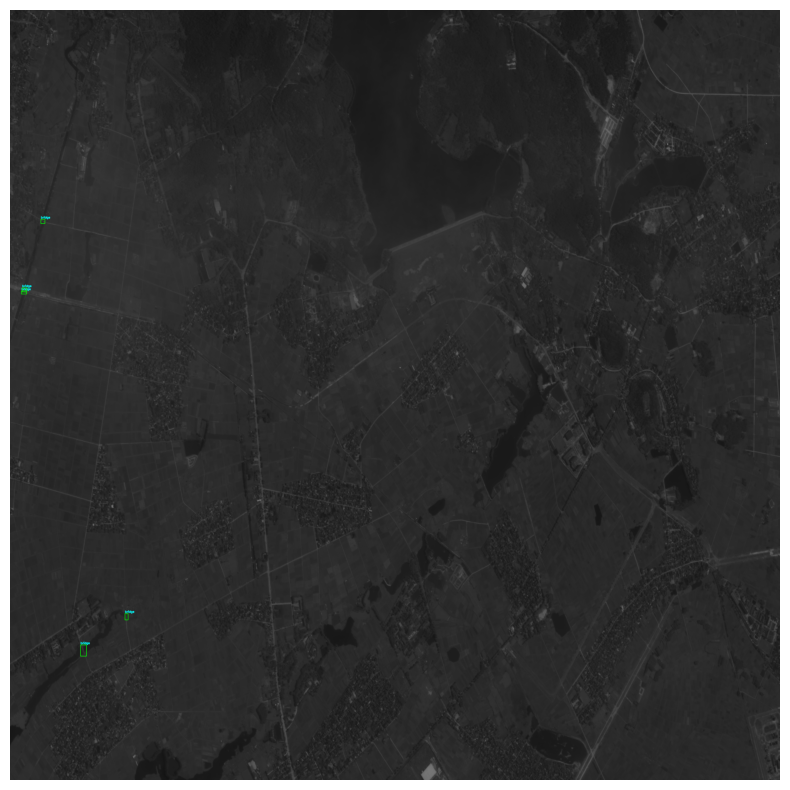

In [35]:
#Visual Check of 5 Random Samples
import cv2
import matplotlib.pyplot as plt
import random

def show_yolo_bbox(img_path, label_path, class_names):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    with open(label_path, 'r') as f:
        labels = f.readlines()

    for line in labels:
        cls, xc, yc, bw, bh = map(float, line.strip().split())
        cls = int(cls)
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, class_names[cls], (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Sample from train set
sample_dir = os.path.join(base_out_dir, 'images', 'train')
sample_lbl_dir = os.path.join(base_out_dir, 'labels', 'train')
sample_imgs = random.sample(os.listdir(sample_dir), 5)

for img_file in sample_imgs:
    img_path = os.path.join(sample_dir, img_file)
    lbl_path = os.path.join(sample_lbl_dir, img_file.replace('.png', '.txt'))
    if os.path.exists(lbl_path):
        print(f" Showing: {img_file}")
        show_yolo_bbox(img_path, lbl_path, data_yaml['names'])
    else:
        print(f"Label missing for {img_file}")